#  Adversarial training


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join,exists

import time 
import numpy as np
import pandas as pd
import cv2
import pickle
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
import gc


from tensorflow import convert_to_tensor
import tensorflow.keras.backend as K
from tensorflow.keras.models import  load_model,Model
from tensorflow.keras import applications
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dropout, Activation, Dense, GlobalMaxPooling2D,Conv2D,Flatten,MaxPooling2D,InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import Loss,CategoricalCrossentropy

import copy

from efficientnet.tfkeras import EfficientNetB7
from tensorflow.keras import datasets
from foolbox.attacks import LinfFastGradientAttack,LinfDeepFoolAttack
from foolbox.distances import LpDistance
from foolbox.models import TensorFlowModel
from foolbox import criteria
from sklearn.metrics import classification_report


from art.attacks.evasion import SaliencyMapMethod
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import BoundaryAttack
from art.utils import load_dataset #to play with cifar images


gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4*1024)]
)

In [3]:
tf.config.run_functions_eagerly(False)

In [4]:
tf.random.set_seed(0)

#### 1. Load Data

In [5]:
data_mnist=datasets.mnist.load_data(path='mnist.npz')
X_train_mnist,y_train_mnist=data_mnist[0][0],data_mnist[0][1]
X_test_mnist,y_test_mnist=data_mnist[1][0],data_mnist[1][1]
y_train_mnist = to_categorical(y_train_mnist, 10)
y_test_mnist = to_categorical(y_test_mnist, 10)

""" Train """
X_train_img_mnist = np.full((60000, 32, 32, 3), 0)
for i, s in enumerate(X_train_mnist):
    X_train_img_mnist[i] = cv2.cvtColor(np.pad(s,2), cv2.COLOR_GRAY2RGB) 
    
""" Test """
X_test_img_mnist = np.full((10000, 32, 32, 3), 0)
for i, s in enumerate(X_test_mnist):
    X_test_img_mnist[i] = cv2.cvtColor(np.pad(s,2), cv2.COLOR_GRAY2RGB) 
    
X_train_mnist=X_train_img_mnist
X_test_mnist= X_test_img_mnist

In [6]:
(X_train_cifar, y_train_cifar), (X_test_cifar, y_test_cifar), _,_=load_dataset('cifar10')
for i, im in enumerate(X_train_cifar):
    X_train_cifar[i]=255*im
for i, im in enumerate(X_test_cifar):
    X_test_cifar[i]=255*im    


dict_classes={}
dict_classes[0]='airplane'
dict_classes[1]='automobile'
dict_classes[2]='bird'
dict_classes[3]='cat'
dict_classes[4]='deer'
dict_classes[5]='dog'
dict_classes[6]='frog'
dict_classes[7]='horse'
dict_classes[8]='ship'
dict_classes[9]='truck'

In [7]:
def pick_data_set(data_set_name):
    
    if data_set_name=='Mnist':
        X_train=X_train_mnist
        X_test= X_test_mnist
        y_train = y_train_mnist
        y_test= y_test_mnist

    elif data_set_name=='Cifar':
        X_train=X_train_cifar
        X_test= X_test_cifar
        y_train = y_train_cifar
        y_test= y_test_cifar  
        
    train_data_set=tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(buffer_size=100000).batch(128)
    
    
    return(train_data_set,X_test,y_test)
    

#### 2. Load models

On défini une classe qui créé des modèles dont la fonction objectif est une combinaison de deux fonction objectifs. La première est une cross-entropie classique et la seconde est une cross-entropie adverse. C'est à dire une fonction qui vise à correctement classifier un exemple adverse 

$$J_{tot}(\theta,x,y)=(1-c)J(\theta,x,y)+cJ(\theta,(x+{\epsilon}sign(\nabla_{x}J(\theta,x,y)),y)$$ 

Pour cela nous avons du réécrire la fonction d'entrainement du modèle afin d'entrainer la bonne fonction objectif

In [8]:
class NewModel(tf.keras.Model):
    def __init__(self,learning_rate,epsilon):
        super(NewModel,self).__init__()
        
        self.c=0
        self.learning_rate=learning_rate
        self.epsilon=epsilon
        
        
        self.effnet_base = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
        self.effnet_base.trainable=True
        x=self.effnet_base.layers[-2].output        
        x=GlobalMaxPooling2D()(x)
        x=Dropout(0.2)(x)
        x=Dense(32)(x)
        x=Dense(10)(x)
        o=Activation('softmax')(x)
        self.model= Model(inputs=self.effnet_base.inputs, outputs=[o])


        
        self.loss = CategoricalCrossentropy()
        self.optimizer = tf.keras.optimizers.Nadam(self.learning_rate)#self.learning_rate)        
        
   
    @tf.function
    def train_step(self,x,y):
        
        with tf.GradientTape() as tape_w:  
            tape_w.watch(self.model.trainable_variables)
            
            with tf.GradientTape() as tape_x:
                tape_x.watch(x)
                true_loss = self.loss(y, self.model(x))        
            gradient = tape_x.gradient(true_loss, x)
            signed_grad = tf.sign(gradient) 
            adv_image=tf.clip_by_value(x+self.epsilon*signed_grad,0,255)
            adv_loss= self.loss(y, self.model(adv_image)) 
           
       
      # Combines both losses            
            total_loss= (1-self.c)*true_loss + self.c*adv_loss
            
    # Regular backward pass.
            gradients = tape_w.gradient(total_loss, self.model.trainable_variables)   
            
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            
       
    def train(self,epochs=5,c_list=[0,0.1,0.3,0.5,0.7,0.9],data_set_list=['Cifar','Mnist']):

                
        for data_set_name in data_set_list:
            
            for c in c_list:
                (train_data_set,X_test,y_test)=pick_data_set(data_set_name)
                print("======= data_set: "+str(data_set_name)+'======')
                print("======= c: "+str(c)+'======')
                self.c=c
                if exists('models/adversarial_training/'+str(data_set_name)+'/c='+str(c)+'.h5')==False:
                    pred=list(map(np.argmax,self.model(X_test[:1000])))
                    true_values=list(map(np.argmax,y_test[:1000]))
                    acc=np.sum([1 for i in range(len(pred)) if pred[i]==true_values[i]])/len(pred)         
                    print('Accuracy before training is {} '.format(acc))
                    print('-----------')
                    for epoch in range(epochs):                        
                        start = time.time()
                        for (x,y) in tqdm(train_data_set,position=0):
                            x=tf.cast(x,dtype='float32')
                            self.train_step(x,y)           

                        pred=list(map(np.argmax,self.model(X_test[:1000])))
                        true_values=list(map(np.argmax,y_test[:1000]))
                        acc=np.sum([1 for i in range(len(pred)) if pred[i]==true_values[i]])/len(pred)         

                        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
                        print('-----------')
                        print('Accuracy for epoch {} is {} '.format(epoch + 1, acc))   
                        
                    self.model.save_weights('models/adversarial_training/'+str(data_set_name)+'/c='+str(c)+'.h5')
                else:
                    self.model.load_weights('models/adversarial_training/'+str(data_set_name)+'/c='+str(c)+'.h5')
                    pred=list(map(np.argmax,self.model(X_test[:1000])))
                    true_values=list(map(np.argmax,y_test[:1000]))
                    acc=np.sum([1 for i in range(len(pred)) if pred[i]==true_values[i]])/len(pred)         

                    print('-----------')
                    print('Accuracy is {} '.format(acc))   
                    
        return()
    
    def call(self, inputs):
        x = self.model(inputs)
        return x


In [9]:
def train_models():
   
    new_model=NewModel(learning_rate=0.0001,epsilon=5)
    new_model.train(epochs=5)
    
    model_to_load_weights_onto=new_model.model
    model_to_load_weights_onto.compile(
            loss='categorical_crossentropy',
            optimizer='nadam',
            metrics=['accuracy']
            )
           
    return(model_to_load_weights_onto)        

In [10]:
def DOC (x_adv_list,x_list):
    N=len(x_adv_list)
    sum=0
    for i in range (N):        
        sum+=100*np.linalg.norm(np.reshape(x_adv_list[i] - x_list[i], -1),ord=1)/np.linalg.norm(np.reshape(x_list[i], -1),ord=1)
    return(sum/N)

def succes_rate (success_list):
    success=len([i for i in success_list if i==True])
    total=len(success_list)
    return(success/total)

Test de la resistance du modèle 

In [11]:
def attack_performances_computer(model_to_attack,predicting_model,attack, image_list, labels,epsilon):
    model_to_attack=TensorFlowModel(model_to_attack , bounds=(0, 255))
   
    success_on_attacked_model=[]
    success_on_predicting_model=[]
    adv_list=[]
    for i,image in enumerate(tqdm(image_list,position=0)):
        image = np.asarray(image)[:,:,:3].astype('float32')
        image = convert_to_tensor(np.expand_dims(image,axis=0))
        label=labels[i]
        label = tf.convert_to_tensor(np.array([label]))
        _, clipped, is_adv = attack(model_to_attack,image,label,epsilons=[epsilon])
        success_on_attacked_model.append(bool(is_adv[0]))
        adv_list.append(np.array(clipped[0]))
        prediction=predicting_model.predict(np.expand_dims(clipped[0][0],axis=0))
        if np.argmax(prediction)!=labels[i]:
            success_on_predicting_model.append(True)
        else:
            success_on_predicting_model.append(False)
            
        
    DOC_attack=DOC(adv_list,image_list)
    SR_on_attacked_model=succes_rate(success_on_attacked_model)
    SR_on_predicting_model=succes_rate(success_on_predicting_model)
    return(DOC_attack,SR_on_attacked_model,SR_on_predicting_model)


In [12]:
def attack_runner(model_to_attack,predicting_model,image_list, labels_list, epislons_list):   
    labels_list=list(map(np.argmax,labels_list))
    
    attack_FGSM=LinfFastGradientAttack()
    SR_FGSM_dic={}  
    SR_FGSM_dic_with_defense={}


    for epsilon in epislons_list:
        print('======'+'epislon: '+str(epsilon)+'======')
        DOC_FGSM,SR_FGSM,SR_FGSM_with_defense=attack_performances_computer(model_to_attack,predicting_model,attack_FGSM, image_list, labels_list,epsilon)
              
        SR_FGSM_dic[DOC_FGSM]=SR_FGSM
        SR_FGSM_dic_with_defense[DOC_FGSM]=SR_FGSM_with_defense
        
    return(SR_FGSM_dic,SR_FGSM_dic_with_defense)

In [13]:
def attacks(data_set_list=['Mnist','Cifar']):
    data_set_plots={}
    for data_set_name in data_set_list:
        (_,X_test,y_test)=pick_data_set(data_set_name)
        model=train_models()
        plots={}
        epsilons=[0.1,1,5,10,25,50,75,100]
        X=X_test[7000:7100]
        y=y_test[7000:7100]
        for c in [0,0.1,0.3,0.5,0.7,0.9]:
            print("======= data_set: "+str(data_set_name)+'======')
            print("======= c: "+str(c)+'======')
            model.load_weights('models/adversarial_training/'+str(data_set_name)+'/c='+str(c)+'.h5')
            if exists('data/efficiency_adv_trained/'+str(data_set_name)+'/c='+str(c))==False:
                plots[c],_=attack_runner(model,model,X, y, epsilons)
                with open('data/efficiency_adv_trained/'+str(data_set_name)+'/c='+str(c), 'wb') as f:
                        pickle.Pickler(f).dump(plots[c])

            else:
                with open('data/efficiency_adv_trained/'+str(data_set_name)+'/c='+str(c), 'rb') as f:
                    plots[c]=pickle.Unpickler(f).load()
        data_set_plots[data_set_name]=plots
    return(data_set_plots)
        
    

In [14]:
data_set_plots=attacks(data_set_list=['Mnist','Cifar'])

======= data_set: Cifar======
======= c: 0======
-----------
Accuracy is 0.327 
======= data_set: Cifar======
======= c: 0.1======
-----------
Accuracy is 0.715 
======= data_set: Cifar======
======= c: 0.3======
-----------
Accuracy is 0.75 
======= data_set: Cifar======
======= c: 0.5======
-----------
Accuracy is 0.818 
======= data_set: Cifar======
======= c: 0.7======
-----------
Accuracy is 0.808 
======= data_set: Cifar======
======= c: 0.9======
-----------
Accuracy is 0.805 
======= data_set: Mnist======
======= c: 0======
-----------
Accuracy is 0.982 
======= data_set: Mnist======
======= c: 0.1======
-----------
Accuracy is 0.986 
======= data_set: Mnist======
======= c: 0.3======
-----------
Accuracy is 0.984 
======= data_set: Mnist======
======= c: 0.5======
-----------
Accuracy is 0.992 
======= data_set: Mnist======
======= c: 0.7======
-----------
Accuracy is 0.985 
======= data_set: Mnist======
======= c: 0.9======
-----------
Accuracy is 0.983 
======= data_set: Mni

  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 5======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 10======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 25======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 50======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 75======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 100======


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


======= data_set: Mnist======
======= c: 0.3======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 5======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 10======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 25======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 50======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 75======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 100======


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


======= data_set: Mnist======
======= c: 0.5======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 5======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 10======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 25======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 50======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 75======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 100======


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


======= data_set: Mnist======
======= c: 0.7======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 5======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 10======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 25======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 50======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 75======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 100======


100%|██████████| 100/100 [00:55<00:00,  1.82it/s]


======= data_set: Mnist======
======= c: 0.9======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 5======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 10======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 25======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 50======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 75======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 100======


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


======= data_set: Cifar======
======= c: 0======
-----------
Accuracy is 0.327 
======= data_set: Cifar======
======= c: 0.1======
-----------
Accuracy is 0.715 
======= data_set: Cifar======
======= c: 0.3======
-----------
Accuracy is 0.75 
======= data_set: Cifar======
======= c: 0.5======
-----------
Accuracy is 0.818 
======= data_set: Cifar======
======= c: 0.7======
-----------
Accuracy is 0.808 
======= data_set: Cifar======
======= c: 0.9======
-----------
Accuracy is 0.805 
======= data_set: Mnist======
======= c: 0======
-----------
Accuracy is 0.982 
======= data_set: Mnist======
======= c: 0.1======
-----------
Accuracy is 0.986 
======= data_set: Mnist======
======= c: 0.3======
-----------
Accuracy is 0.984 
======= data_set: Mnist======
======= c: 0.5======
-----------
Accuracy is 0.992 
======= data_set: Mnist======
======= c: 0.7======
-----------
Accuracy is 0.985 
======= data_set: Mnist======
======= c: 0.9======
-----------
Accuracy is 0.983 
======= data_set: Cif

  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 5======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 10======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 25======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 50======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 75======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 100======


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


======= data_set: Cifar======
======= c: 0.1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 5======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 10======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 25======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 50======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 75======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 100======


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


======= data_set: Cifar======
======= c: 0.3======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 5======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 10======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 25======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 50======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 75======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 100======


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


======= data_set: Cifar======
======= c: 0.5======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 5======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 10======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 25======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 50======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 75======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 100======


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


======= data_set: Cifar======
======= c: 0.7======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 5======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 10======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 25======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 50======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 75======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 100======


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


======= data_set: Cifar======
======= c: 0.9======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 0.1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 1======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 5======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 10======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 25======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 50======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 75======


  0%|          | 0/100 [00:00<?, ?it/s]

======epislon: 100======


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


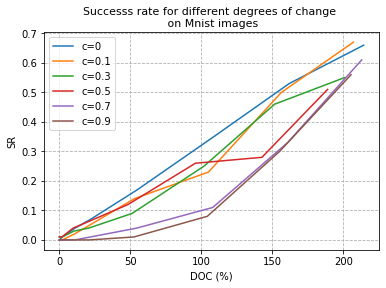

In [15]:
for c,plot in data_set_plots['Mnist'].items():
    plt.plot(list(plot.keys()),list(plot.values()),label='c='+str(c))
plt.grid(True,which="both", linestyle='--')
plt.title('Successs rate for different degrees of change \n on Mnist images',fontsize=11)
plt.xlabel('DOC (%)')
plt.ylabel('SR')
plt.legend(loc='upper left')

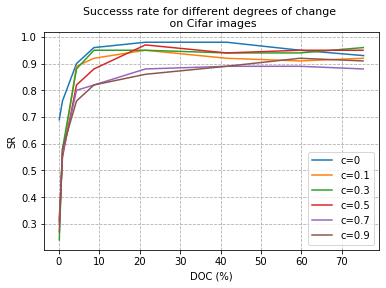

In [18]:
for c,plot in data_set_plots['Cifar'].items():
    plt.plot(list(plot.keys()),list(plot.values()),label='c='+str(c))
plt.grid(True,which="both", linestyle='--')
plt.title('Successs rate for different degrees of change \n on Cifar images',fontsize=11)
plt.xlabel('DOC (%)')
plt.ylabel('SR')
plt.legend(loc='lower right')

Clearly the adversarial training has decreased the efficiency of the attacks so it is truly beneficial. It seems that the higher c is and the better the protection

Let's save the 'best model' --> c=0.9

### Softmax probabilities visualizations

At first let's create some adversarial examples that will fool the most basic model

In [ ]:
models_dict=train_models('Mnist')
(_,X_test,y_test)=pick_data_set('Mnist')

In [ ]:
model_naif=models_dict[0]
model_to_attack=TensorFlowModel(model_naif , bounds=(0, 255))
attack=LinfFastGradientAttack()
image_list=X_test[:100]
labels=list(map(np.argmax,y_test[:100]))
adv_list=[]
true_label=[]
for i,image in enumerate(tqdm(image_list,position=0)):
    image = np.asarray(image)[:,:,:3].astype('float32')
    image = convert_to_tensor(np.expand_dims(image,axis=0))
    label=labels[i]
    label = tf.convert_to_tensor(np.array([label]))
    _, clipped, is_adv = attack(model_to_attack,image,label,epsilons=50)
    if bool(is_adv[0])==True:
        adv_list.append(np.array(clipped[0]))
        true_label.append(labels[i])
    

Let's visualize the outputs of the softmax layers of the different models when given the adversarial images 

In [ ]:
adv_image_num=9


plt.figure(figsize=(10,10))
ax = plt.subplot(3, 3, 2)
plt.imshow(adv_list[adv_image_num].astype('int32'))
for i,c in enumerate([0,0.1,0.3,0.5,0.7,0.9]): 
    ax = plt.subplot(3, 3, 3+i + 1)
    color=['blue' for i in range(10)]
    prediction=models_dict[c].predict(np.expand_dims(adv_list[adv_image_num],axis=0))[0]
    if np.argmax(prediction)==true_label[adv_image_num]:
        color[true_label[adv_image_num]]='green'
    else:
        color[np.argmax(prediction)]='red'
    plt.bar(x=[i for i in range(10)], height=prediction,color=color)
    plt.title('c: '+str(c))


In [ ]:
adv_image_num=10


plt.figure(figsize=(10,10))
ax = plt.subplot(3, 3, 2)
plt.imshow(adv_list[adv_image_num].astype('int32'))
for i,c in enumerate([0,0.1,0.3,0.5,0.7,0.9]): 
    ax = plt.subplot(3, 3, 3+i + 1)
    color=['blue' for i in range(10)]
    prediction=models_dict[c].predict(np.expand_dims(adv_list[adv_image_num],axis=0))[0]
    if np.argmax(prediction)==true_label[adv_image_num]:
        color[true_label[adv_image_num]]='green'
    else:
        color[np.argmax(prediction)]='red'
    plt.bar(x=[i for i in range(10)], height=prediction,color=color)
    plt.title('c: '+str(c))

### Against a black box attack (boundary attack)

In [ ]:
model_without_def=models_dict[0]


classifier = TensorFlowV2Classifier(model=model_without_def, input_shape=(32,32,3),clip_values=(0, 255),nb_classes=10)
degree_of_change_without_def={}
attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=0, delta=0.001, epsilon=0.01)
iter_step =1
target=X_test[1]
image_list=[]
x_adv = None
for i in range(100):
    x_adv = attack.generate(x=np.array([target]), x_adv_init=x_adv)

    #clear_output()
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - target, [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    plt.imshow(x_adv[0][..., ::-1].astype('int32'))
    image_list.append(x_adv[0][..., ::-1].astype(np.uint))
    plt.show(block=False)
    degree_of_change_without_def[i * iter_step]=DOC([x_adv[0]],[target])
    
    if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step 
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break

In [ ]:
model_with_def=models_dict[0.9]

classifier = TensorFlowV2Classifier(model=model_with_def, input_shape=(32,32,3),clip_values=(0, 255),nb_classes=10)
degree_of_change_with_def={}
attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=0, delta=0.001, epsilon=0.01)
iter_step =1
image_list=[]
target=X_test[1]
x_adv = None
for i in range(100):
    x_adv = attack.generate(x=np.array([target]), x_adv_init=x_adv)

    #clear_output()
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - target, [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    plt.imshow(x_adv[0][..., ::-1].astype('int32'))
    image_list.append(x_adv[0][..., ::-1].astype(np.uint))
    plt.show(block=False)
    degree_of_change_with_def[i * iter_step]=DOC([x_adv[0]],[target])
    
    if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step 
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break


In [ ]:
plt.plot(list(degree_of_change_without_def.keys()),list(degree_of_change_without_def.values()),label='DOC without adversarial training')
plt.plot(list(degree_of_change_with_def.keys()),list(degree_of_change_with_def.values()),label='DOC with adversarial training')
plt.grid(True,which="both", linestyle='--')
plt.title('DOC of the adversarial image with respect to the number of iterations on a small CNN', fontsize=8)
plt.xlabel('Iterarion')
plt.ylabel('DOC (%)')

plt.legend(loc='upper right')
plt.show()